# RNN for One Step Prediction of One Cell

## 1. Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv', index_col='Timestamp')
df.head()

,Cell_000111,Cell_000112,Cell_000113,Cell_000231,Cell_000232,Cell_000233,Cell_000461,Cell_000462,Cell_000463,Cell_000821,...,Cell_006653,Cell_006661,Cell_006662,Cell_006663,Cell_007371,Cell_007372,Cell_007373,Cell_039871,Cell_039872,Cell_039873
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-23 00:00:00,29.26490,59.15291,59.01721,2.63658,14.11635,3.37565,7.69811,0.62042,0.74651,0.00000,...,36.89798,148.60854,98.66328,6.60830,0.82699,3.27327,80.90784,18.22045,6.99716,1.73569
2017-10-23 01:00:00,19.26170,60.22876,40.34814,13.16293,0.96246,7.47019,31.07216,0.52249,14.31437,19.78196,...,35.80842,11.13813,0.43016,1.45869,0.73014,0.35795,1.58017,38.19131,9.75174,7.38484
2017-10-23 02:00:00,18.37236,14.83900,1.27435,25.36683,1.07481,3.88256,26.14190,1.10567,27.31817,0.00000,...,42.86074,39.93543,0.28038,1.09835,0.38237,0.66306,0.75476,1.29435,3.66695,2.57090
2017-10-23 03:00:00,18.69268,0.98166,2.11746,1.66842,0.85055,14.04557,0.56444,0.50090,12.28002,0.00000,...,55.43529,10.91845,4.04031,5.95218,0.50307,0.26729,1.32703,1.01926,0.17117,11.62664
2017-10-23 04:00:00,21.62559,4.28219,3.51484,1.78151,0.71691,12.94846,27.45815,17.99582,5.18661,0.00033,...,16.57459,46.98406,0.89364,5.47769,4.58068,0.30167,1.20668,0.82393,123.40943,28.72087


## 2. Fill NaNs

In [3]:
ndf = df.interpolate(method='linear', axis=1) # linear interpolate
#ndf = df.fillna(method='ffill', axis=1) # forward the last valid observation
ndf = df.fillna(0) # fill remaned nans with 0s
ndf.isna().sum().sum()

0

## 3. Train-Test Split

In [4]:
cell_name = 'Cell_000463'
data = ndf[cell_name].values
data = data.astype('float32')
data.shape

(8738,)

In [5]:
ratio = 0.8
train_size = int(ratio*len(data))
train = data[:train_size]
test = data[train_size:]
print(train.shape)
print(test.shape)

(6990,)
(1748,)


## 4. Min-Max Scaling

In [6]:
# min-max scaling
Min = min(train)
Max = max(train)
train_scaled = (train - Min)/(Max - Min)
test_scaled = (test - Min)/(Max - Min)
print("Min: ", Min)
print("Max: ", Max)
# reshape 
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1)
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1)

Min:  0.12346
Max:  5373.0864


## 5. Time Series Generators

In [7]:
days_back = 2 # back days for prediction
n_inputs = 24*days_back # number of inputs
n_outputs = 1 # number of outputs
batch_size = 16
train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(train_scaled,
                                                                train_scaled,
                                                                length=n_inputs,
                                                                batch_size=batch_size)
test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(test_scaled,
                                                               test_scaled,
                                                               length=n_inputs,
                                                               batch_size=batch_size)
print("Number of train samples: ", len(train_gen))
print("Number of test samples: ", len(test_gen))

Number of train samples:  427
Number of test samples:  99


## 6. Simple RNN Model

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32,
                                    activation='tanh',
                                    input_shape=(n_inputs, 1)))
model.add(tf.keras.layers.Dense(n_outputs))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',
             loss='mean_squared_error')

In [10]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=test_gen,
                    verbose=0)

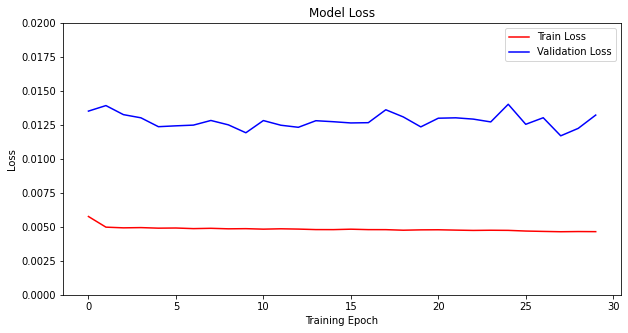

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim((0,0.02))
plt.legend()
plt.show()

In [12]:
print(f"Min SimpleRNN Loss: {min(val_loss):.4f}")

Min SimpleRNN Loss: 0.0117


## 7. LSTM Model

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32,
                               activation='tanh',
                               input_shape=(n_inputs, 1)))
model.add(tf.keras.layers.Dense(n_outputs))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='rmsprop',
             loss='mean_squared_error')

In [15]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=test_gen,
                    verbose=0)

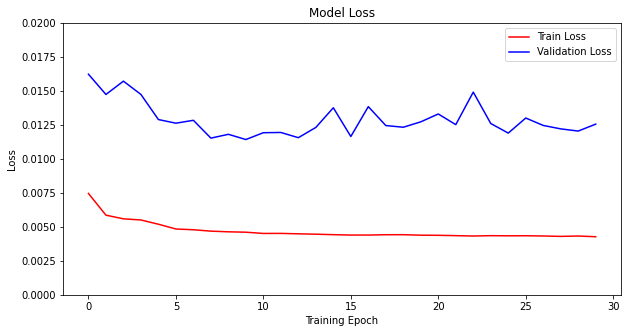

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim((0,0.02))
plt.legend()
plt.show()

In [17]:
print(f"Min LSTM Loss: {min(val_loss):.4f}")

Min LSTM Loss: 0.0114


## 8. GRU Model

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(32,
                              activation='tanh',
                              input_shape=(n_inputs, 1)))
model.add(tf.keras.layers.Dense(n_outputs))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='rmsprop',
             loss='mean_squared_error')

In [20]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=test_gen,
                    verbose=0)

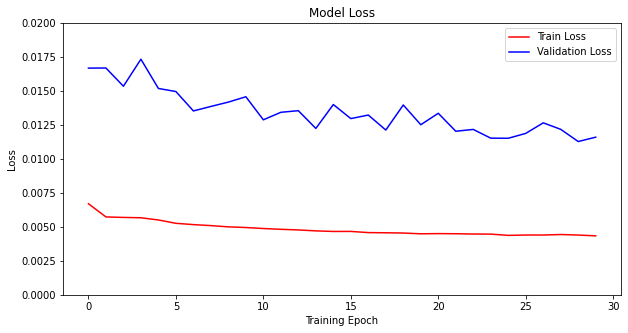

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim((0,0.02))
plt.legend()
plt.show()

In [22]:
print(f"Min GRU Loss: {min(val_loss):.4f}")

Min GRU Loss: 0.0113
